In [1]:
import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [256]:
gp = GaussianProcessRegressor(kernel=RBF())

In [269]:
x = np.linspace(0.1, 5, 50)
curves = gp.sample_y(x.reshape((50, 1)), 2)
f1 = curves[:, 0]
f2 = curves[:, 1]

In [39]:
from statsmodels.nonparametric.smoothers_lowess import lowess

x = np.linspace(0.1, 5, 50)

q = 6
r = 2

phi1 = 0.75
phi2 = -0.05

F = np.random.normal(0, 0.5, [50, r])
for t in range(1, 50):
    F[t, 0] = phi1 * F[t - 1, 0] + F[t, 0]
    F[t, 1] = phi2 * F[t - 1, 1] + F[t, 1]
F[:, 0] = lowess(F[:, 0], x, is_sorted = True, frac = 0.1, it = 1)[:, 1]
F[:, 1] = lowess(F[:, 1], x, is_sorted = True, frac = 0.1, it = 1)[:, 1]
loading = np.random.normal(0, 1, [r, q])
sigma2_eps = [0.1 for i in range(1, q + 1)]
eps = np.random.multivariate_normal(np.repeat(0, q), np.diag(sigma2_eps), 50)
Y = np.matmul(F, loading) + eps
f1 = F[:, 0]
f2 = F[:, 1]

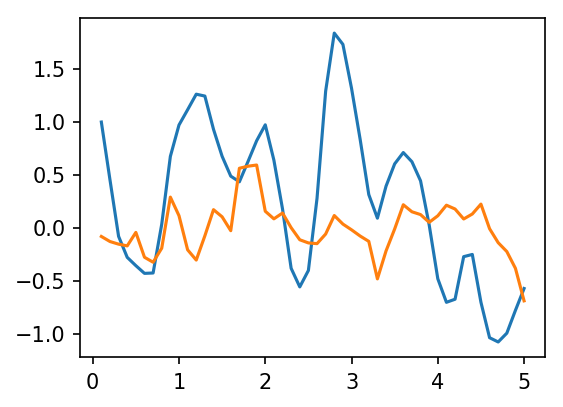

In [40]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(x, f1)
plt.plot(x, f2)
plt.show()

In [272]:
F = np.zeros((50, 2))
F[:, 0] = f1
F[:, 1] = f2

In [273]:
loading = np.random.normal(0, 1, [2, 6])
Y_true = np.matmul(F, loading)
Y = Y_true + np.random.normal(0, 0.2, [50, 6])

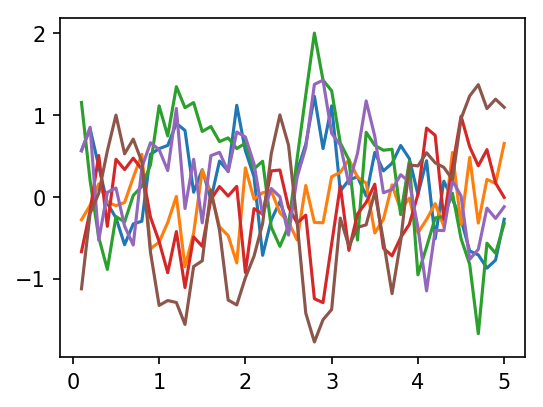

In [41]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for j in range(6):
    plt.plot(x, Y[:, j])
plt.show()

In [42]:
from sklearn.decomposition import PCA

In [43]:
latent_dim = 2
pca = PCA(n_components=latent_dim)
components = pca.fit_transform(Y)

In [44]:
Y_hat = pca.inverse_transform(components)
mse = np.mean((Y - Y_hat) ** 2)
print(mse)

0.059593020349772485


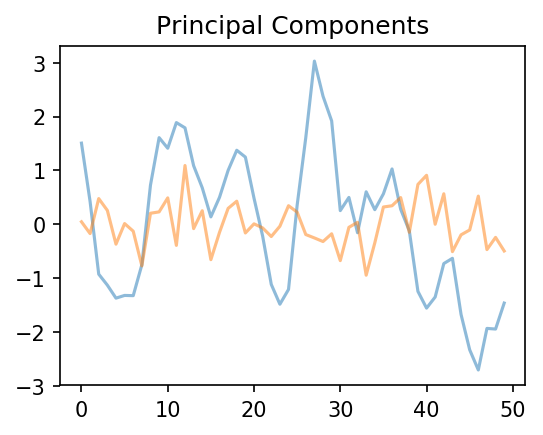

In [45]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for j in range(2):
    plt.plot(components[:, j], alpha=0.5)
plt.title('Principal Components')
plt.show()

In [48]:
from gibbs import *

In [124]:
loading_matrix = np.random.normal(0, 1, [2, 6])
Y_variance = np.random.normal(0, 0.1, 6) ** 2
X = x.reshape((50, 1))
cov1 = sample_covariance(X, 1.0, 1.0)  # length scale 1.0 corresponds to 10 time points
cov2 = sample_covariance(X, 1.0, 1.0)  # variance scale set to 1.0 as well
S1, S2, S3, S4 = build_covariance_blocks([cov1, cov2], loading_matrix, Y_variance)
F, cov = sample_conditional_F(Y, S1, S2, S3, S4, debug=True)

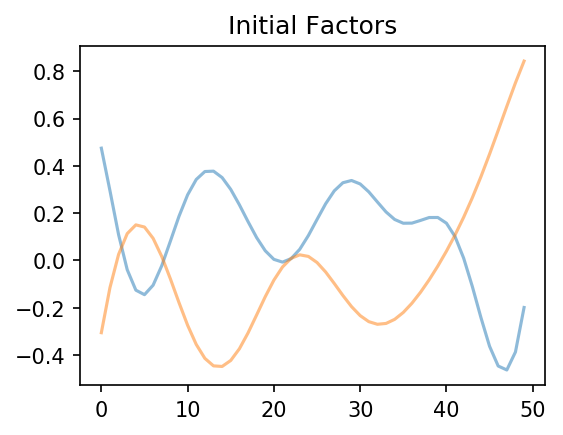

In [125]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for j in range(2):
    plt.plot(F[:, j], alpha=0.5)
plt.title('Initial Factors')
plt.show()

In [78]:
from model import *

In [101]:
def sample_gp_posterior(F_column, n_sample=100, gprior_params=(10, 0.1),  prior_scale=0.5, sigma=1e-3, test=False):
	"""
	Sample from GP posterior given one column of F (single factor).
	
	Args
		F_column: (numpy array) [t] latent observations at t time points
		n_sample: (int) MCMC chain length
		gprior_params: (tuple) Gamma prior on length scale (distance between adjacent time points is always 0.1)
		prior_scale: (float) half-Cauchy prior scale
		sigma: (float) Gaussian process noise (set to small number for noise free latent process)
		test: (bool) test mode returns the trace
	"""
	t = F_column.shape[0]
	X = np.linspace(0.1, t * 0.1, t).reshape((t, 1))
	with pm.Model() as model:
		l = pm.Gamma('l', gprior_params[0], gprior_params[1])  # informative prior for length scale
		K = 1.0 ** 2 * pm.gp.cov.ExpQuad(1, l)  
		#K = s ** 2 * pm.gp.cov.Matern32(1, l)  # Matern (nu=1.5) kernel
		gp = pm.gp.Marginal(cov_func=K)
		y_ = gp.marginal_likelihood('y', X=X, y=F_column, noise=sigma)
		trace = pm.sample(n_sample, Metropolis(), chains=1)  # use Metropolis instead of NUTS for speed
		#trace = pm.sample(n_sample)
	l = trace['l'][-1]
	cov = sample_covariance(X, l, 1.0)
	#mu, cov = gp.predict(X, point=trace[-1])
	if test:
		return cov, trace
	else:
		return cov

In [102]:
def gibbs_sampling(F, Y, verbose=True):
	""" 
	One Gibbs sampling step to update everything else given F then draw from conditional of F.
	"""
	latent_dim = F.shape[1]
	mu_0 = np.repeat(0, latent_dim)  # prior mean 0 for regression coefficients
	Sigma_0 = np.diag(np.repeat(1, latent_dim))  # prior variance 1
	a_0 = 1  # Inverse-Gamma(1, 1) is fairly diffused
	b_0 = 1
	loading_matrix, Y_variance = blr_mv(Y, F, mu_0, Sigma_0, a_0, b_0)
	Y_hat = np.matmul(F, loading_matrix)
	mse = np.mean((Y - Y_hat) ** 2)
	if verbose:
		print(mse)
	covs = []
	gp_traces = []
	for j in range(latent_dim):
		cov, gp_trace = sample_gp_posterior(F[:, j], test=True)
		covs.append(cov)
		gp_traces.append(gp_trace)
	S1, S2, S3, S4 = build_covariance_blocks(covs, loading_matrix, Y_variance)
	F = sample_conditional_F(Y, S1, S2, S3, S4)
	return F, loading_matrix, Y_variance, gp_traces, mse

In [103]:
def run_model_sampler(Y, initial_F, n_iter):
    """
    Create model and run Gibbs sampler for n iterations.
    """
    F_sample = []
    loading_sample = []
    variance_sample = []
    trace_sample = []
    mse_history = []
    F = initial_F
    for i in tqdm(range(n_iter)):
        F, loading_matrix, Y_variance, gp_traces, mse = gibbs_sampling(F, Y)
        F_sample.append(F)
        loading_sample.append(loading_matrix)
        variance_sample.append(Y_variance)
        trace_sample.append(gp_traces)
        mse_history.append(mse)
    return F_sample, loading_sample, variance_sample, trace_sample, mse_history

In [126]:
results = run_model_sampler(Y, F, 50)





  0%|          | 0/50 [00:00<?, ?it/s]

0.21001259027579292


INFO (theano.gof.compilelock): Refreshing lock /Users/linggeli/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 25%|██▌       | 150/600 [00:00<00:00, 1494.34it/s]




 48%|████▊     | 291/600 [00:00<00:00, 1466.89it/s]




 71%|███████   | 426/600 [00:00<00:00, 1427.95it/s]




 94%|█████████▍| 567/600 [00:00<00:00, 1419.65it/s]




100%|██████████| 600/600 [00:00<00:00, 1375.58it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 26%|██▌       | 153/600 [00:00<00:00, 1527.45it/s]




 53%|█████▎    | 316/600 [00:00<00:00, 1554.70it/s]




 80%|███████▉  | 477/600 [00:00<00:00, 1570.11it/s]




100%|██████████| 600/600 [00:00<00:00, 1536.45it/s]Only one chain 

0.17619316326771917


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 23%|██▎       | 138/600 [00:00<00:00, 1375.53it/s]




 50%|████▉     | 298/600 [00:00<00:00, 1435.65it/s]




 78%|███████▊  | 467/600 [00:00<00:00, 1503.21it/s]




100%|██████████| 600/600 [00:00<00:00, 1555.12it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 22%|██▎       | 135/600 [00:00<00:00, 1349.01it/s]




 47%|████▋     | 281/600 [00:00<00:00, 1379.19it/s]




 72%|███████▏  | 431/600 [00:00<00:00, 1412.72it/s]




 96%|█████████▋| 579/600 [00:00<00:00, 1430.39it/s]




100%|██████████| 600/600 [00:00<00:00, 1374.38it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




  4%|▍         | 2/50 [00:28<11:31, 14.40s/it]

0.16973188547817672


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 24%|██▍       | 147/600 [00:00<00:00, 1464.04it/s]




 51%|█████▏    | 308/600 [00:00<00:00, 1502.89it/s]




 76%|███████▌  | 455/600 [00:00<00:00, 1492.39it/s]




 96%|█████████▋| 578/600 [00:00<00:00, 1391.20it/s]




100%|██████████| 600/600 [00:00<00:00, 1361.39it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 26%|██▌       | 154/600 [00:00<00:00, 1538.83it/s]




 53%|█████▎    | 318/600 [00:00<00:00, 1566.04it/s]




 80%|████████  | 482/600 [00:00<00:00, 1586.56it/s]




100%|██████████| 600/600 [00:00<00:00, 1538.28it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




  6%|▌         | 3/50 [00:43<11:20, 14.48s/it]

0.174593939528872


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 22%|██▏       | 133/600 [00:00<00:00, 1324.04it/s]




 47%|████▋     | 284/600 [00:00<00:00, 1374.45it/s]




 72%|███████▎  | 435/600 [00:00<00:00, 1411.21it/s]




 98%|█████████▊| 585/600 [00:00<00:00, 1434.83it/s]




100%|██████████| 600/600 [00:00<00:00, 1399.07it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 23%|██▎       | 137/600 [00:00<00:00, 1369.92it/s]




 48%|████▊     | 289/600 [00:00<00:00, 1410.81it/s]




 75%|███████▌  | 450/600 [00:00<00:00, 1463.75it/s]




100%|██████████| 600/600 [00:00<00:00, 1520.83it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




  8%|▊         | 4/50 [00:57<11:04, 14.44s/it]

0.17894202716549037


INFO (theano.gof.compilelock): Refreshing lock /Users/linggeli/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 22%|██▏       | 134/600 [00:00<00:00, 1334.61it/s]




 50%|████▉     | 297/600 [00:00<00:00, 1410.83it/s]




 76%|███████▋  | 459/600 [00:00<00:00, 1467.40it/s]




100%|██████████| 600/600 [00:00<00:00, 1534.79it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 20%|██        | 122/600 [00:00<00:00, 1216.30it/s]




 47%|████▋     | 284/600 [00:00<00:00, 1313.52it/s]




 75%|███████▌  | 450/600 [00:00<00:00, 1398.71it/s]




100%|██████████| 600/600 [00:00<00:00, 1519.90it/s]Only one chain was sampled, this makes it impossible to run some conver

0.1641545309431779


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 22%|██▏       | 134/600 [00:00<00:00, 1339.69it/s]




 50%|████▉     | 298/600 [00:00<00:00, 1417.19it/s]




 78%|███████▊  | 467/600 [00:00<00:00, 1488.36it/s]




100%|██████████| 600/600 [00:00<00:00, 1523.41it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 22%|██▎       | 135/600 [00:00<00:00, 1346.66it/s]




 50%|████▉     | 299/600 [00:00<00:00, 1421.26it/s]




 78%|███████▊  | 467/600 [00:00<00:00, 1488.93it/s]




100%|██████████| 600/600 [00:00<00:00, 1552.37it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 12%|█▏        | 6/50 [01:26<10:37, 14.50s/it]

0.16626445099621434


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 26%|██▌       | 157/600 [00:00<00:00, 1563.87it/s]




 53%|█████▎    | 317/600 [00:00<00:00, 1573.70it/s]




 80%|████████  | 483/600 [00:00<00:00, 1596.54it/s]




100%|██████████| 600/600 [00:00<00:00, 1572.10it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 24%|██▍       | 147/600 [00:00<00:00, 1469.97it/s]




 52%|█████▏    | 310/600 [00:00<00:00, 1512.60it/s]




 77%|███████▋  | 464/600 [00:00<00:00, 1519.79it/s]




100%|██████████| 600/600 [00:00<00:00, 1549.03it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 14%|█▍        | 7/50 [01:41<10:25, 14.54s/it]

0.14407696491779462


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 24%|██▍       | 147/600 [00:00<00:00, 1464.51it/s]




 50%|█████     | 303/600 [00:00<00:00, 1490.87it/s]




 78%|███████▊  | 468/600 [00:00<00:00, 1533.52it/s]




100%|██████████| 600/600 [00:00<00:00, 1526.95it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 13%|█▎        | 79/600 [00:00<00:00, 789.95it/s]




 36%|███▌      | 216/600 [00:00<00:00, 904.58it/s]




 62%|██████▏   | 369/600 [00:00<00:00, 1029.35it/s]




 86%|████████▌ | 516/600 [00:00<00:00, 1128.73it/s]




100%|██████████| 600/600 [00:00<00:00, 1279.22it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 16%|█▌        | 8/50 [01:56<10:11, 14.55s/it]

0.14569425161900273


INFO (theano.gof.compilelock): Refreshing lock /Users/linggeli/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 29%|██▊       | 172/600 [00:00<00:00, 1718.73it/s]




 53%|█████▎    | 316/600 [00:00<00:00, 1621.31it/s]




 82%|████████▏ | 489/600 [00:00<00:00, 1650.25it/s]




100%|██████████| 600/600 [00:00<00:00, 1639.09it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 29%|██▉       | 175/600 [00:00<00:00, 1741.83it/s]




 60%|█████▉    | 359/600 [00:00<00:00, 1769.41it/s]




 92%|█████████▏| 552/600 [00:00<00:00, 1813.33it/s]




100%|██████████| 600/600 [00:00<00:00, 1801.33it/s]Only one chain was sampled, this makes it impossible to run some conver

0.14776051970618762


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 26%|██▌       | 154/600 [00:00<00:00, 1530.66it/s]




 55%|█████▍    | 327/600 [00:00<00:00, 1584.41it/s]




 81%|████████  | 484/600 [00:00<00:00, 1578.59it/s]




100%|██████████| 600/600 [00:00<00:00, 1568.82it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 24%|██▍       | 145/600 [00:00<00:00, 1446.46it/s]




 47%|████▋     | 284/600 [00:00<00:00, 1427.07it/s]




 75%|███████▍  | 448/600 [00:00<00:00, 1481.35it/s]




100%|██████████| 600/600 [00:00<00:00, 1508.58it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 20%|██        | 10/50 [02:28<10:18, 15.46s/it]

0.1468618040096222


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 23%|██▎       | 139/600 [00:00<00:00, 1388.78it/s]




 48%|████▊     | 289/600 [00:00<00:00, 1419.47it/s]




 76%|███████▌  | 456/600 [00:00<00:00, 1485.09it/s]




100%|██████████| 600/600 [00:00<00:00, 1507.18it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 17%|█▋        | 101/600 [00:00<00:00, 1008.21it/s]




 43%|████▎     | 259/600 [00:00<00:00, 1130.25it/s]




 70%|███████   | 422/600 [00:00<00:00, 1244.59it/s]




 96%|█████████▋| 578/600 [00:00<00:00, 1323.58it/s]




100%|██████████| 600/600 [00:00<00:00, 1404.85it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 22%|██▏       | 11/50 [02:43<09:57, 15.31s/it]

0.12957674749096532


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 27%|██▋       | 160/600 [00:00<00:00, 1594.02it/s]




 55%|█████▍    | 327/600 [00:00<00:00, 1614.15it/s]




 84%|████████▍ | 506/600 [00:00<00:00, 1662.93it/s]




100%|██████████| 600/600 [00:00<00:00, 1636.03it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 29%|██▉       | 173/600 [00:00<00:00, 1726.49it/s]




 60%|█████▉    | 358/600 [00:00<00:00, 1760.41it/s]




 91%|█████████ | 546/600 [00:00<00:00, 1794.43it/s]




100%|██████████| 600/600 [00:00<00:00, 1794.32it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 24%|██▍       | 12/50 [02:58<09:34, 15.11s/it]

0.1299300256844154


INFO (theano.gof.compilelock): Refreshing lock /Users/linggeli/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 27%|██▋       | 162/600 [00:00<00:00, 1616.53it/s]




 49%|████▉     | 293/600 [00:00<00:00, 1508.25it/s]




 70%|██████▉   | 417/600 [00:00<00:00, 1415.15it/s]




 97%|█████████▋| 584/600 [00:00<00:00, 1481.84it/s]




100%|██████████| 600/600 [00:00<00:00, 1430.48it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 22%|██▏       | 134/600 [00:00<00:00, 1339.77it/s]




 46%|████▌     | 277/600 [00:00<00:00, 1364.48it/s]




 75%|███████▌  | 450/600 [00:00<00:00, 1456.80it/s]




100%|██████████| 600/600 [00:00<00:00, 1566.63it/s]Only one chain 

0.11839796266431472


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 20%|██        | 122/600 [00:00<00:00, 1219.17it/s]




 47%|████▋     | 281/600 [00:00<00:00, 1308.63it/s]




 70%|███████   | 423/600 [00:00<00:00, 1339.23it/s]




 98%|█████████▊| 587/600 [00:00<00:00, 1417.13it/s]




100%|██████████| 600/600 [00:00<00:00, 1441.69it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 28%|██▊       | 169/600 [00:00<00:00, 1684.88it/s]




 60%|█████▉    | 358/600 [00:00<00:00, 1739.91it/s]




 92%|█████████▏| 549/600 [00:00<00:00, 1785.50it/s]




100%|██████████| 600/600 [00:00<00:00, 1795.83it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 28%|██▊       | 14/50 [03:30<09:22, 15.64s/it]

0.12300540149152502


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 19%|█▉        | 114/600 [00:00<00:00, 1129.64it/s]




 40%|████      | 243/600 [00:00<00:00, 1172.24it/s]




 65%|██████▌   | 390/600 [00:00<00:00, 1247.76it/s]




 88%|████████▊ | 526/600 [00:00<00:00, 1278.33it/s]




100%|██████████| 600/600 [00:00<00:00, 1293.42it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 12%|█▏        | 72/600 [00:00<00:00, 718.64it/s]




 38%|███▊      | 228/600 [00:00<00:00, 857.09it/s]




 63%|██████▎   | 378/600 [00:00<00:00, 983.52it/s]




 90%|████████▉ | 537/600 [00:00<00:00, 1110.45it/s]




100%|██████████| 600/600 [00:00<00:00, 1319.42it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 30%|███       | 1

0.11168915325092911


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




  0%|          | 1/600 [00:00<07:04,  1.41it/s]




 26%|██▌       | 157/600 [00:00<03:39,  2.01it/s]




 53%|█████▎    | 320/600 [00:00<01:37,  2.88it/s]




 77%|███████▋  | 461/600 [00:01<00:33,  4.11it/s]




100%|██████████| 600/600 [00:01<00:00, 546.37it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 21%|██        | 126/600 [00:00<00:00, 1259.01it/s]




 47%|████▋     | 284/600 [00:00<00:00, 1339.99it/s]




 74%|███████▍  | 447/600 [00:00<00:00, 1414.48it/s]




100%|██████████| 600/600 [00:00<00:00, 1501.59it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 32%|███▏      | 16/50 [04:00<08:43, 15.41s/it]

0.11822388906229998


INFO (theano.gof.compilelock): Refreshing lock /Users/linggeli/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 21%|██▏       | 128/600 [00:00<00:00, 1274.98it/s]




 47%|████▋     | 280/600 [00:00<00:00, 1339.26it/s]




 72%|███████▏  | 434/600 [00:00<00:00, 1393.16it/s]




100%|█████████▉| 597/600 [00:00<00:00, 1455.84it/s]




100%|██████████| 600/600 [00:00<00:00, 1463.39it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 24%|██▍       | 143/600 [00:00<00:00, 1423.35it/s]




 50%|█████     | 302/600 [00:00<00:00, 1469.00it/s]




 78%|███████▊  | 466/600 [00:00<00:00, 1514.77it/s]




100%|██████████| 600/600 [00:00<00:00, 1543.77it/s]Only one chain 

0.1147798035693565


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




  9%|▊         | 52/600 [00:00<00:01, 517.91it/s]




 25%|██▌       | 150/600 [00:00<00:00, 602.66it/s]




 45%|████▌     | 272/600 [00:00<00:00, 710.10it/s]




 72%|███████▎  | 435/600 [00:00<00:00, 854.42it/s]




100%|█████████▉| 597/600 [00:00<00:00, 995.17it/s]




100%|██████████| 600/600 [00:00<00:00, 1177.07it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 12%|█▎        | 75/600 [00:00<00:00, 748.74it/s]




 31%|███       | 184/600 [00:00<00:00, 825.01it/s]




 56%|█████▌    | 336/600 [00:00<00:00, 955.35it/s]




 75%|███████▍  | 449/600 [00:00<00:00, 1001.20it/s]




 95%|█████████▍| 569/600 [00:00<00:00, 1051.12it/s]




100%|██████████| 600/600 [00:00<00:00, 1129.29it/s]

0.12181351913894406


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 26%|██▌       | 155/600 [00:00<00:00, 1547.88it/s]




 53%|█████▎    | 320/600 [00:00<00:00, 1575.80it/s]




 81%|████████  | 486/600 [00:00<00:00, 1599.41it/s]




100%|██████████| 600/600 [00:00<00:00, 1589.26it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 18%|█▊        | 108/600 [00:00<00:00, 1076.01it/s]




 35%|███▍      | 208/600 [00:00<00:00, 1050.39it/s]




 53%|█████▎    | 320/600 [00:00<00:00, 1069.51it/s]




 76%|███████▌  | 455/600 [00:00<00:00, 1137.37it/s]




 91%|█████████ | 545/600 [00:00<00:00, 948.20it/s] 




100%|██████████| 600/600 [00:00<00:00, 963.59it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 38%|███▊      

0.11500083619935826


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 12%|█▏        | 71/600 [00:00<00:00, 708.93it/s]




 31%|███       | 187/600 [00:00<00:00, 802.37it/s]




 57%|█████▊    | 345/600 [00:00<00:00, 940.84it/s]




 81%|████████  | 484/600 [00:00<00:00, 1041.48it/s]




 98%|█████████▊| 585/600 [00:00<00:00, 1028.62it/s]




100%|██████████| 600/600 [00:00<00:00, 1087.70it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 29%|██▉       | 174/600 [00:00<00:00, 1733.20it/s]




 60%|██████    | 361/600 [00:00<00:00, 1769.66it/s]




 91%|█████████ | 546/600 [00:00<00:00, 1792.30it/s]




100%|██████████| 600/600 [00:00<00:00, 1784.51it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 40%|████      | 2

0.11531853441206551


INFO (theano.gof.compilelock): Refreshing lock /Users/linggeli/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 27%|██▋       | 160/600 [00:00<00:00, 1583.96it/s]




 52%|█████▏    | 312/600 [00:00<00:00, 1563.48it/s]




 78%|███████▊  | 468/600 [00:00<00:00, 1561.09it/s]




100%|██████████| 600/600 [00:00<00:00, 1567.65it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 28%|██▊       | 165/600 [00:00<00:00, 1648.88it/s]




 58%|█████▊    | 348/600 [00:00<00:00, 1697.20it/s]




 86%|████████▌ | 515/600 [00:00<00:00, 1687.94it/s]




100%|██████████| 600/600 [00:00<00:00, 1710.46it/s]Only one chain was sampled, this makes it impossible to run some conver

0.11806974631317307


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 19%|█▊        | 112/600 [00:00<00:00, 1111.60it/s]




 40%|████      | 242/600 [00:00<00:00, 1159.49it/s]




 62%|██████▏   | 374/600 [00:00<00:00, 1200.84it/s]




 84%|████████▎ | 502/600 [00:00<00:00, 1221.25it/s]




100%|██████████| 600/600 [00:00<00:00, 1299.16it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 17%|█▋        | 101/600 [00:00<00:00, 1009.75it/s]




 40%|███▉      | 237/600 [00:00<00:00, 1094.20it/s]




 68%|██████▊   | 406/600 [00:00<00:00, 1222.50it/s]




 97%|█████████▋| 584/600 [00:00<00:00, 1348.86it/s]




100%|██████████| 600/600 [00:00<00:00, 1421.17it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 44%|████▍    

0.11861455501008446


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 25%|██▌       | 152/600 [00:00<00:00, 1519.57it/s]




 53%|█████▎    | 318/600 [00:00<00:00, 1557.27it/s]




 84%|████████▎ | 501/600 [00:00<00:00, 1628.55it/s]




100%|██████████| 600/600 [00:00<00:00, 1679.62it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 28%|██▊       | 171/600 [00:00<00:00, 1707.01it/s]




 59%|█████▉    | 353/600 [00:00<00:00, 1736.97it/s]




 90%|████████▉ | 539/600 [00:00<00:00, 1769.99it/s]




100%|██████████| 600/600 [00:00<00:00, 1763.29it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 46%|████▌     | 23/50 [05:48<06:55, 15.38s/it]

0.1250338798127478


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 30%|██▉       | 177/600 [00:00<00:00, 1769.77it/s]




 61%|██████    | 367/600 [00:00<00:00, 1804.74it/s]




 93%|█████████▎| 557/600 [00:00<00:00, 1832.18it/s]




100%|██████████| 600/600 [00:00<00:00, 1817.32it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 21%|██        | 124/600 [00:00<00:00, 1239.89it/s]




 49%|████▉     | 296/600 [00:00<00:00, 1352.99it/s]




 76%|███████▌  | 457/600 [00:00<00:00, 1419.17it/s]




100%|██████████| 600/600 [00:00<00:00, 1497.80it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 48%|████▊     | 24/50 [06:03<06:34, 15.16s/it]

0.11666044900430433


INFO (theano.gof.compilelock): Refreshing lock /Users/linggeli/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




  9%|▊         | 52/600 [00:00<00:01, 517.26it/s]




 15%|█▌        | 90/600 [00:00<00:01, 466.68it/s]




 29%|██▉       | 174/600 [00:00<00:00, 537.56it/s]




 49%|████▉     | 293/600 [00:00<00:00, 642.97it/s]




 74%|███████▎  | 442/600 [00:00<00:00, 774.80it/s]




 89%|████████▊ | 532/600 [00:00<00:00, 741.81it/s]




100%|██████████| 600/600 [00:00<00:00, 841.91it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 30%|██▉       | 177/600 [00:00<00:00, 1764.85it/s]




 59%|█████▊    | 352/600 [00:00<00:00, 1759.93it/s]




 83%|████████▎ | 50

0.11070551081148933


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 28%|██▊       | 167/600 [00:00<00:00, 1669.27it/s]




 57%|█████▋    | 340/600 [00:00<00:00, 1686.12it/s]




 87%|████████▋ | 522/600 [00:00<00:00, 1722.70it/s]




100%|██████████| 600/600 [00:00<00:00, 1698.36it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 27%|██▋       | 163/600 [00:00<00:00, 1624.91it/s]




 55%|█████▍    | 329/600 [00:00<00:00, 1633.18it/s]




 87%|████████▋ | 521/600 [00:00<00:00, 1707.59it/s]




100%|██████████| 600/600 [00:00<00:00, 1716.32it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 52%|█████▏    | 26/50 [06:35<06:16, 15.68s/it]

0.11382050767135614


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 27%|██▋       | 162/600 [00:00<00:00, 1615.12it/s]




 51%|█████     | 306/600 [00:00<00:00, 1557.42it/s]




 72%|███████▏  | 431/600 [00:00<00:00, 1449.18it/s]




 94%|█████████▎| 562/600 [00:00<00:00, 1403.62it/s]




100%|██████████| 600/600 [00:00<00:00, 1373.96it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 28%|██▊       | 167/600 [00:00<00:00, 1665.68it/s]




 58%|█████▊    | 348/600 [00:00<00:00, 1706.06it/s]




 88%|████████▊ | 530/600 [00:00<00:00, 1738.11it/s]




100%|██████████| 600/600 [00:00<00:00, 1742.29it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 54%|█████▍    | 27/50 [06:51<05:58, 15.60s/it]

0.11937788643001578


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 29%|██▉       | 174/600 [00:00<00:00, 1733.91it/s]




 60%|██████    | 361/600 [00:00<00:00, 1770.96it/s]




 92%|█████████▏| 553/600 [00:00<00:00, 1810.84it/s]




100%|██████████| 600/600 [00:00<00:00, 1799.16it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 28%|██▊       | 171/600 [00:00<00:00, 1707.92it/s]




 59%|█████▉    | 354/600 [00:00<00:00, 1742.04it/s]




 90%|████████▉ | 539/600 [00:00<00:00, 1771.09it/s]




100%|██████████| 600/600 [00:00<00:00, 1767.61it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 56%|█████▌    | 28/50 [07:05<05:33, 15.16s/it]

0.11929569121497165


INFO (theano.gof.compilelock): Refreshing lock /Users/linggeli/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 30%|██▉       | 178/600 [00:00<00:00, 1772.13it/s]




 61%|██████▏   | 368/600 [00:00<00:00, 1806.47it/s]




 93%|█████████▎| 560/600 [00:00<00:00, 1838.78it/s]




100%|██████████| 600/600 [00:00<00:00, 1817.66it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 29%|██▉       | 176/600 [00:00<00:00, 1752.33it/s]




 60%|█████▉    | 357/600 [00:00<00:00, 1768.22it/s]




 92%|█████████▏| 549/600 [00:00<00:00, 1811.01it/s]




100%|██████████| 600/600 [00:00<00:00, 1797.36it/s]Only one chain was sampled, this makes it impossible to run some conver

0.12055436810594077


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 30%|██▉       | 177/600 [00:00<00:00, 1764.42it/s]




 61%|██████    | 366/600 [00:00<00:00, 1798.68it/s]




 92%|█████████▏| 554/600 [00:00<00:00, 1820.85it/s]




100%|██████████| 600/600 [00:00<00:00, 1804.45it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 29%|██▉       | 176/600 [00:00<00:00, 1751.80it/s]




 60%|█████▉    | 359/600 [00:00<00:00, 1773.04it/s]




 91%|█████████▏| 548/600 [00:00<00:00, 1806.28it/s]




100%|██████████| 600/600 [00:00<00:00, 1781.36it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 60%|██████    | 30/50 [07:33<04:52, 14.62s/it]

0.11610628842245203


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 29%|██▉       | 176/600 [00:00<00:00, 1756.35it/s]




 61%|██████    | 364/600 [00:00<00:00, 1789.61it/s]




 93%|█████████▎| 556/600 [00:00<00:00, 1826.44it/s]




100%|██████████| 600/600 [00:00<00:00, 1809.94it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 26%|██▋       | 159/600 [00:00<00:00, 1583.78it/s]




 51%|█████     | 304/600 [00:00<00:00, 1538.48it/s]




 78%|███████▊  | 471/600 [00:00<00:00, 1575.23it/s]




100%|██████████| 600/600 [00:00<00:00, 1581.76it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 62%|██████▏   | 31/50 [07:47<04:35, 14.52s/it]

0.11705835451997369


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 22%|██▎       | 135/600 [00:00<00:00, 1349.23it/s]




 38%|███▊      | 228/600 [00:00<00:00, 1187.33it/s]




 48%|████▊     | 285/600 [00:00<00:00, 858.90it/s] 




 71%|███████   | 427/600 [00:00<00:00, 974.17it/s]




 96%|█████████▋| 579/600 [00:00<00:00, 1090.08it/s]




100%|██████████| 600/600 [00:00<00:00, 1094.68it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 22%|██▏       | 129/600 [00:00<00:00, 1283.86it/s]




 42%|████▏     | 252/600 [00:00<00:00, 1263.33it/s]




 70%|██████▉   | 419/600 [00:00<00:00, 1360.74it/s]




100%|██████████| 600/600 [00:00<00:00, 1498.05it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 64%|██████▍   

0.1156727555395878


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 27%|██▋       | 163/600 [00:00<00:00, 1623.04it/s]




 55%|█████▌    | 331/600 [00:00<00:00, 1637.54it/s]




 84%|████████▍ | 503/600 [00:00<00:00, 1658.39it/s]




100%|██████████| 600/600 [00:00<00:00, 1653.15it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
INFO (theano.gof.compilelock): Refreshing lock /Users/linggeli/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 26%|██▌       | 154/600 [00:00<00:00, 1538.00it/s]




 50%|████▉     | 298/600 [00:00<00:00, 1494.70it/s]




 76%|███████▌  | 455/600 [00:00<00:00, 1515.46it/s]




100%|██████████| 600/600 [00:00<00:00, 1566.10it/s]Only one chain was sampled, this makes it impossible to run some conver

0.10957150886735169


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 24%|██▍       | 147/600 [00:00<00:00, 1464.55it/s]




 44%|████▍     | 266/600 [00:00<00:00, 1368.57it/s]




 72%|███████▏  | 431/600 [00:00<00:00, 1440.96it/s]




 99%|█████████▉| 595/600 [00:00<00:00, 1492.14it/s]




100%|██████████| 600/600 [00:00<00:00, 1458.69it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 21%|██▏       | 128/600 [00:00<00:00, 1276.49it/s]




 44%|████▍     | 264/600 [00:00<00:00, 1300.29it/s]




 64%|██████▎   | 381/600 [00:00<00:00, 1256.67it/s]




 83%|████████▎ | 497/600 [00:00<00:00, 1225.79it/s]




 99%|█████████▉| 595/600 [00:00<00:00, 1138.60it/s]




100%|██████████| 600/600 [00:00<00:00, 1161.63it/s]Only one chain was sampled, this makes it impo

0.11239897749333021


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 28%|██▊       | 167/600 [00:00<00:00, 1668.62it/s]




 55%|█████▌    | 332/600 [00:00<00:00, 1661.05it/s]




 84%|████████▎ | 501/600 [00:00<00:00, 1668.44it/s]




100%|██████████| 600/600 [00:00<00:00, 1666.96it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 12%|█▏        | 72/600 [00:00<00:00, 717.87it/s]




 21%|██▏       | 128/600 [00:00<00:00, 660.12it/s]




 30%|██▉       | 179/600 [00:00<00:00, 605.42it/s]




 44%|████▎     | 262/600 [00:00<00:00, 657.86it/s]




 57%|█████▋    | 343/600 [00:00<00:00, 696.75it/s]




 70%|███████   | 422/600 [00:00<00:00, 721.17it/s]




 83%|████████▎ | 498/600 [00:00<00:00, 731.01it/s]




 99%|█████████▉| 593/600 [00:00<00:00, 785.20it/s

0.11038714934691339


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 19%|█▉        | 116/600 [00:00<00:00, 1158.54it/s]




 43%|████▎     | 259/600 [00:00<00:00, 1227.20it/s]




 70%|███████   | 420/600 [00:00<00:00, 1321.30it/s]




 97%|█████████▋| 583/600 [00:00<00:00, 1400.20it/s]




100%|██████████| 600/600 [00:00<00:00, 1427.24it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 22%|██▏       | 130/600 [00:00<00:00, 1296.20it/s]




 48%|████▊     | 287/600 [00:00<00:00, 1366.88it/s]




 75%|███████▍  | 448/600 [00:00<00:00, 1431.05it/s]




100%|██████████| 600/600 [00:00<00:00, 1503.19it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 72%|███████▏  | 36/50 [09:07<03:37, 15.52s/it]

0.11588735906570799


INFO (theano.gof.compilelock): Refreshing lock /Users/linggeli/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 23%|██▎       | 137/600 [00:00<00:00, 1369.89it/s]




 47%|████▋     | 284/600 [00:00<00:00, 1397.25it/s]




 72%|███████▏  | 431/600 [00:00<00:00, 1417.36it/s]




 98%|█████████▊| 591/600 [00:00<00:00, 1466.59it/s]




100%|██████████| 600/600 [00:00<00:00, 1441.46it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 17%|█▋        | 103/600 [00:00<00:00, 1029.04it/s]




 43%|████▎     | 258/600 [00:00<00:00, 1143.28it/s]




 63%|██████▎   | 376/600 [00:00<00:00, 1153.90it/s]




 84%|████████▍ | 506/600 [00:00<00:00, 1193.17it/s]




100%|█████

0.11026431463125821


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 24%|██▍       | 143/600 [00:00<00:00, 1429.51it/s]




 50%|████▉     | 298/600 [00:00<00:00, 1463.07it/s]




 74%|███████▍  | 445/600 [00:00<00:00, 1464.57it/s]




100%|██████████| 600/600 [00:00<00:00, 1495.14it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 21%|██▏       | 128/600 [00:00<00:00, 1276.46it/s]




 50%|████▉     | 297/600 [00:00<00:00, 1377.24it/s]




 70%|██████▉   | 417/600 [00:00<00:00, 1316.50it/s]




 95%|█████████▍| 569/600 [00:00<00:00, 1371.59it/s]




100%|██████████| 600/600 [00:00<00:00, 1410.98it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 76%|███████▌  | 38/50 [09:36<03:02, 15.17s/it]

0.1139295249177862


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 26%|██▌       | 154/600 [00:00<00:00, 1535.21it/s]




 44%|████▎     | 262/600 [00:00<00:00, 1359.73it/s]




 60%|██████    | 363/600 [00:00<00:00, 1231.03it/s]




 86%|████████▌ | 516/600 [00:00<00:00, 1306.84it/s]




100%|██████████| 600/600 [00:00<00:00, 1306.36it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 28%|██▊       | 165/600 [00:00<00:00, 1646.66it/s]




 58%|█████▊    | 349/600 [00:00<00:00, 1698.07it/s]




 85%|████████▍ | 509/600 [00:00<00:00, 1665.38it/s]




100%|██████████| 600/600 [00:00<00:00, 1581.90it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 78%|███████▊  | 39/50 [09:53<02:50, 15.54s/it]

0.11109320960287891


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 29%|██▉       | 176/600 [00:00<00:00, 1755.89it/s]




 59%|█████▉    | 355/600 [00:00<00:00, 1763.69it/s]




 89%|████████▉ | 536/600 [00:00<00:00, 1775.28it/s]




100%|██████████| 600/600 [00:00<00:00, 1744.67it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 27%|██▋       | 162/600 [00:00<00:00, 1616.11it/s]




 58%|█████▊    | 350/600 [00:00<00:00, 1686.48it/s]




 89%|████████▊ | 532/600 [00:00<00:00, 1724.22it/s]




100%|██████████| 600/600 [00:00<00:00, 1747.86it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 80%|████████  | 40/50 [10:07<02:32, 15.26s/it]

0.11599711001672318


INFO (theano.gof.compilelock): Refreshing lock /Users/linggeli/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 28%|██▊       | 168/600 [00:00<00:00, 1673.02it/s]




 58%|█████▊    | 348/600 [00:00<00:00, 1707.77it/s]




 89%|████████▉ | 533/600 [00:00<00:00, 1747.14it/s]




100%|██████████| 600/600 [00:00<00:00, 1748.08it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 22%|██▏       | 132/600 [00:00<00:00, 1307.63it/s]




 32%|███▏      | 191/600 [00:00<00:00, 934.39it/s] 




 43%|████▎     | 258/600 [00:00<00:00, 834.04it/s]




 62%|██████▏   | 371/600 [00:00<00:00, 904.67it/s]




 88%|████████▊ | 526/600 [00:00<00:00, 1033.08it/s]




100%|███████

0.11880895516891418


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 23%|██▎       | 136/600 [00:00<00:00, 1359.28it/s]




 44%|████▎     | 262/600 [00:00<00:00, 1327.59it/s]




 69%|██████▉   | 414/600 [00:00<00:00, 1379.58it/s]




 95%|█████████▌| 570/600 [00:00<00:00, 1429.10it/s]




100%|██████████| 600/600 [00:00<00:00, 1383.57it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 25%|██▍       | 148/600 [00:00<00:00, 1477.37it/s]




 47%|████▋     | 283/600 [00:00<00:00, 1436.07it/s]




 74%|███████▎  | 441/600 [00:00<00:00, 1474.57it/s]




100%|██████████| 600/600 [00:00<00:00, 1496.63it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 84%|████████▍ | 42/50 [10:39<02:03, 15.47s/it]

0.1145689358078273


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 22%|██▏       | 133/600 [00:00<00:00, 1324.09it/s]




 43%|████▎     | 256/600 [00:00<00:00, 1293.36it/s]




 65%|██████▍   | 389/600 [00:00<00:00, 1303.49it/s]




 86%|████████▌ | 515/600 [00:00<00:00, 1288.79it/s]




100%|██████████| 600/600 [00:00<00:00, 1245.14it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 16%|█▋        | 99/600 [00:00<00:00, 985.81it/s]




 38%|███▊      | 228/600 [00:00<00:00, 1060.26it/s]




 59%|█████▊    | 352/600 [00:00<00:00, 1102.01it/s]




 80%|████████  | 481/600 [00:00<00:00, 1151.49it/s]




100%|██████████| 600/600 [00:00<00:00, 1201.55it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 86%|████████▌ |

0.11676487905525694


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 15%|█▍        | 89/600 [00:00<00:00, 887.40it/s]




 26%|██▋       | 158/600 [00:00<00:00, 815.59it/s]




 40%|███▉      | 238/600 [00:00<00:00, 810.48it/s]




 50%|█████     | 300/600 [00:00<00:00, 741.99it/s]




 64%|██████▍   | 383/600 [00:00<00:00, 765.43it/s]




 80%|████████  | 480/600 [00:00<00:00, 816.41it/s]




100%|██████████| 600/600 [00:00<00:00, 868.41it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 21%|██        | 124/600 [00:00<00:00, 1232.47it/s]




 46%|████▌     | 273/600 [00:00<00:00, 1298.73it/s]




 68%|██████▊   | 411/600 [00:00<00:00, 1320.31it/s]




 95%|█████████▌| 571/600 [00:00<00:00, 1393.00it/s]




100%|██████████| 600/600 [00:00<00:00, 1357.68it/

0.11837728985861347


INFO (theano.gof.compilelock): Refreshing lock /Users/linggeli/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 19%|█▉        | 113/600 [00:00<00:00, 1128.79it/s]




 41%|████      | 244/600 [00:00<00:00, 1177.49it/s]




 62%|██████▏   | 373/600 [00:00<00:00, 1208.35it/s]




 82%|████████▏ | 489/600 [00:00<00:00, 1191.75it/s]




100%|██████████| 600/600 [00:00<00:00, 1218.35it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 28%|██▊       | 166/600 [00:00<00:00, 1656.64it/s]




 55%|█████▌    | 332/600 [00:00<00:00, 1656.97it/s]




 86%|████████▋ | 518/600 [00:00<00:00, 1712.31it/s]




100%|██████████| 600/600 [00:00<00:00, 1715.86it/s]Only one chain 

0.11236245515777886


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




  5%|▌         | 30/600 [00:00<00:02, 281.30it/s]




  8%|▊         | 50/600 [00:00<00:02, 250.51it/s]




 22%|██▏       | 131/600 [00:00<00:01, 315.98it/s]




 28%|██▊       | 167/600 [00:00<00:01, 327.62it/s]




 51%|█████▏    | 308/600 [00:00<00:00, 425.49it/s]




 69%|██████▉   | 414/600 [00:00<00:00, 518.57it/s]




 88%|████████▊ | 530/600 [00:00<00:00, 621.29it/s]




100%|██████████| 600/600 [00:00<00:00, 783.73it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 26%|██▋       | 159/600 [00:00<00:00, 1587.51it/s]




 50%|█████     | 301/600 [00:00<00:00, 1532.57it/s]




 71%|███████   | 425/600 [00:00<00:00, 1423.67it/s]




 96%|█████████▌| 576/600 [00:00<00:00, 1444.86it/s]

0.116404608897336


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 17%|█▋        | 101/600 [00:00<00:00, 1002.73it/s]




 43%|████▎     | 259/600 [00:00<00:00, 1126.01it/s]




 71%|███████▏  | 428/600 [00:00<00:00, 1249.83it/s]




100%|██████████| 600/600 [00:00<00:00, 1503.23it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 20%|██        | 122/600 [00:00<00:00, 1218.23it/s]




 47%|████▋     | 284/600 [00:00<00:00, 1315.45it/s]




 70%|███████   | 420/600 [00:00<00:00, 1327.07it/s]




 97%|█████████▋| 581/600 [00:00<00:00, 1398.32it/s]




100%|██████████| 600/600 [00:00<00:00, 1383.63it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




 94%|█████████▍| 47/50 [12:00<00:49, 16.52s/it]

0.11177718097665845


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 12%|█▏        | 71/600 [00:00<00:00, 709.44it/s]




 37%|███▋      | 221/600 [00:00<00:00, 841.71it/s]




 56%|█████▌    | 337/600 [00:00<00:00, 916.48it/s]




 72%|███████▏  | 433/600 [00:00<00:00, 923.98it/s]




 94%|█████████▎| 561/600 [00:00<00:00, 1007.72it/s]




100%|██████████| 600/600 [00:00<00:00, 1098.95it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 23%|██▎       | 140/600 [00:00<00:00, 1398.60it/s]




 47%|████▋     | 284/600 [00:00<00:00, 1408.94it/s]




 74%|███████▍  | 444/600 [00:00<00:00, 1459.45it/s]




 98%|█████████▊| 589/600 [00:00<00:00, 1455.21it/s]




100%|██████████| 600/600 [00:00<00:00, 1435.25it/s]Only one chain was sampled, this makes it impossibl

0.12357129040659942


INFO (theano.gof.compilelock): Refreshing lock /Users/linggeli/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 21%|██        | 124/600 [00:00<00:00, 1236.72it/s]




 46%|████▌     | 277/600 [00:00<00:00, 1311.46it/s]




 72%|███████▏  | 431/600 [00:00<00:00, 1372.10it/s]




 98%|█████████▊| 587/600 [00:00<00:00, 1422.16it/s]




100%|██████████| 600/600 [00:00<00:00, 1430.57it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 21%|██        | 125/600 [00:00<00:00, 1245.48it/s]




 46%|████▌     | 276/600 [00:00<00:00, 1314.06it/s]




 72%|███████▏  | 433/600 [00:00<00:00, 1381.34it/s]




 97%|█████████▋| 584/600 [00:00<00:00, 1416.89it/s]




100%|█████

0.1133900518065298


Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




  8%|▊         | 46/600 [00:00<00:01, 457.79it/s]




 23%|██▎       | 140/600 [00:00<00:00, 540.97it/s]




 44%|████▍     | 265/600 [00:00<00:00, 651.69it/s]




 61%|██████    | 366/600 [00:00<00:00, 729.22it/s]




 78%|███████▊  | 467/600 [00:00<00:00, 794.73it/s]




100%|██████████| 600/600 [00:00<00:00, 1000.75it/s]Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
Metropolis: [l]





  0%|          | 0/600 [00:00<?, ?it/s]




 23%|██▎       | 140/600 [00:00<00:00, 1394.08it/s]




 48%|████▊     | 290/600 [00:00<00:00, 1422.40it/s]




 76%|███████▌  | 454/600 [00:00<00:00, 1480.85it/s]




100%|██████████| 600/600 [00:00<00:00, 1507.44it/s]Only one chain was sampled, this makes it impossible to run some convergence checks




100%|██████████| 50/

In [128]:
F_sample, loading_sample, variance_sample, trace_sample, mse_history = results

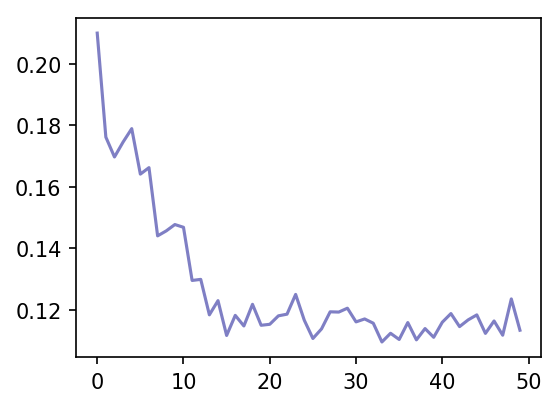

In [129]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(mse_history, alpha=0.5, color='darkblue')
plt.show()

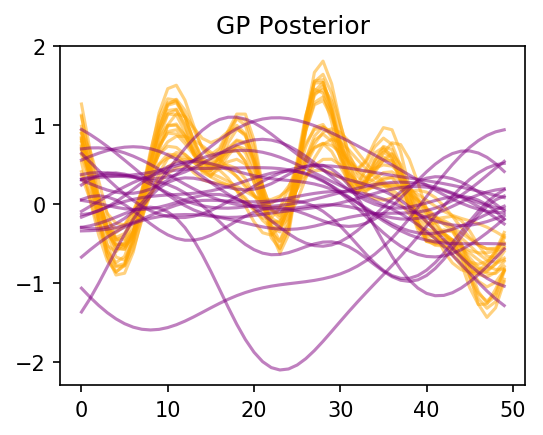

In [135]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(20):
    plt.plot(F_sample[i][:, 0], alpha=0.5, color='orange')
for i in range(20):
    plt.plot(F_sample[i][:, 1], alpha=0.5, color='purple')
#for j in range(2):
#    plt.plot(components[:, j], alpha=0.5, lw=4)
plt.title('GP Posterior')
plt.show()

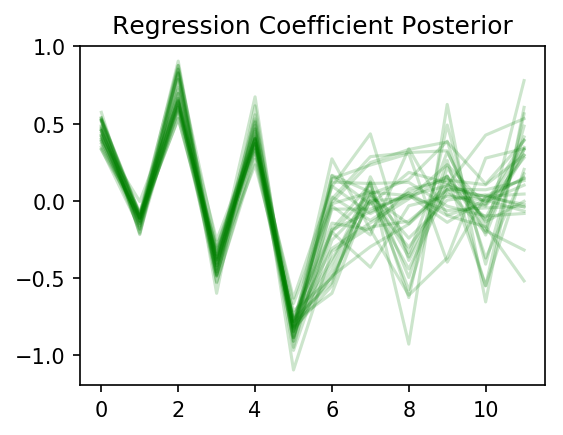

In [132]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(20, 50):
    plt.plot(loading_sample[i].flatten(), alpha=0.2, color='green')
#plt.plot(loading.flatten(), color='red')
plt.title('Regression Coefficient Posterior')
plt.show()

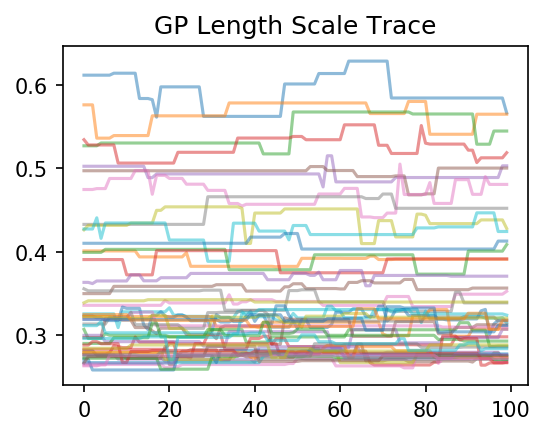

In [133]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(50):
    plt.plot(trace_sample[i][0]['l'], alpha=0.5)
plt.title('GP Length Scale Trace')
plt.show()

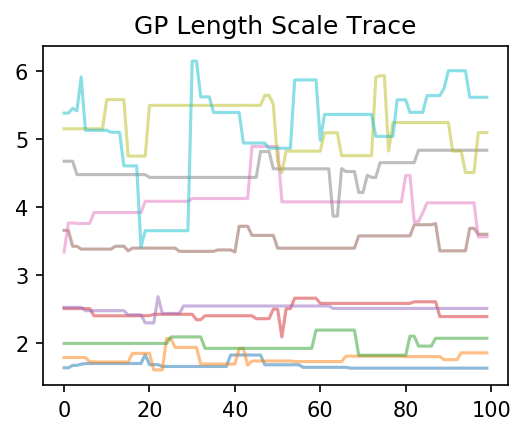

In [134]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(40, 50):
    plt.plot(trace_sample[i][1]['l'], alpha=0.5)
plt.title('GP Length Scale Trace')
plt.show()